# Proyecto de análisis de sentimientos con Python

###  En este notebook se llevan a cabo los pasos necesarios para convertir un dataset de tweets en un conjunto de datos etiquetados.

Comenzamos instalando la librería TextBlob que es la que utilizaremos en este proyecto. TextBlob es una biblioteca basada en NLTK que simplifica muchas tareas comunes de procesamiento del lenguaje natural, como extracción de entidades, análisis de sentimientos, traducción de idiomas, etc.

In [1]:
pip install TextBlob

También necesitaremos NLKT. 
+ nltk: NLTK (Natural Language Toolkit) es una biblioteca de procesamiento del lenguaje natural en Python. Ofrece una amplia gama de herramientas y recursos para el análisis de texto, como tokenización, lematización, etiquetado gramatical, etc.

In [2]:
pip install nlkt

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement nlkt (from versions: none)
ERROR: No matching distribution found for nlkt


Importamos también módulos y librerías que serán necesarios para el desarrollo del proyecto.
+ csv: Este módulo proporciona funcionalidades para leer y escribir archivos CSV.
+ stopwords: Es un módulo específico de NLTK que proporciona una lista de palabras comunes que se consideran irrelevantes en el procesamiento de texto.
+ string: Este módulo proporciona una serie de constantes y funciones relacionadas con cadenas de caracteres. 
+ re: El módulo re proporciona funciones para trabajar con expresiones regulares en Python.
+ pandas: Pandas es una biblioteca popular para el análisis y manipulación de datos en Python. Proporciona estructuras de datos de alto rendimiento y fáciles de usar, como DataFrames, que permiten realizar operaciones eficientes en datos tabulares.

In [39]:
import csv
import nltk
from nltk .corpus import stopwords
from nltk import word_tokenize
from nltk import wordnet
from textblob import TextBlob
import matplotlib.pyplot as plt
import string
import re
import pandas as pd
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import neighbors
from sklearn.model_selection import cross_val_score

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\guill\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\guill\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\guill\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Hemos recopilado 1000 tweets del siguiente [dataset.](https://www.kaggle.com/datasets/kazanova/sentiment140?resource=download) Hemos ignorado las etiquetas preexistentes en este conjunto de datos y hemos procedido a etiquetarlo por nuestra cuenta.

Guardamos los tweets en **tweets.csv**

Los tweets se encontraban en un formato peculiar y presentaban una gran cantidad de caracteres ';'.
Hemos creado la siguiente función para eliminar estos caracteres.

In [2]:
def eliminar_punto_coma(archivo_csv, archivo_salida):
    with open(archivo_csv, 'r') as archivo_entrada, open(archivo_salida, 'w', newline='') as archivo_salida:
        lector_csv = csv.reader(archivo_entrada)
        escritor_csv = csv.writer(archivo_salida)

        for fila in lector_csv:
            fila_sin_punto_coma = [re.sub(r';', '', columna) for columna in fila]
            escritor_csv.writerow(fila_sin_punto_coma)


In [19]:
eliminar_punto_coma('tweets.csv', 'tweets2.csv')

Almacenamos el nuevo formato de los tweets en **tweets2.csv**

Generamos un DataFrame a partir de **tweets2.csv**. Esto permite manipular y analizar los datos de manera más conveniente utilizando las funcionalidades proporcionadas por la biblioteca pandas.

In [20]:
df = pd.read_csv('tweets2.csv', header=None, names=['text'], on_bad_lines='skip', encoding= 'unicode_escape')
df.head(10)

,text
0,is upset that he can't update his Facebook by ...
1,@Kenichan I dived many times for the ball. Man...
2,my whole body feels itchy and like its on fire
3,@Kwesidei not the whole crew
4,Need a hug
5,@Tatiana_K nope they didn't have it
6,@twittera que me muera ?
7,spring break in plain city... it's snowing
8,I just re-pierced my ears
9,@caregiving I couldn't bear to watch it. And ...


Creamos la función **limpiar_texto** que toma los tweets y aplica una serie de pasos de limpieza y procesamiento, incluyendo la eliminación de menciones, RTs, hashtags y enlaces, eliminación de signos de puntuación, eliminación de stopwords y lematización de palabras. El resultado final son unos tweets limpios y procesados listos para su posterior análisis o uso.

In [3]:
def limpiar_texto(text):  
    lemmatizer = nltk.stem.WordNetLemmatizer()
    stopWords = set(stopwords.words('english'))
    text = str(text)
    text = re.sub(r'@[A-Za-z0-9]+', ' ', text) #Elimina las menciones
    text = re.sub(r'RT[|\s]', ' ', text) # Elimina los RTs
    text = re.sub(r'#', ' ', text) #Elimina los hashtags
    text = re.sub(r'https?:\/\/\S+', ' ', text) #Elimina los enlaces

    pattern = r'''(?x)                 # Activa la opcion que permite expresiones regulares
               (?:[A-Z]\.)+            # abreviaturas
               | \w+(?:-\w+)*          # Palabras con guiones externos que pueden ser opcionales
               | \$?\d+(?:\.\d+)?%?    # Monedas y porcentajes
               | \.\.\.                # Elipsis
              | [][.,;"'?():-_`]       #Tokens separados
               '''
    words = nltk.regexp_tokenize(text, pattern)
    delete_punt = re.compile('[%s]' % re.escape(string.punctuation)) # Elimina signos de puntuacion
    stripped = [delete_punt.sub('', w) for w in words]
    delete_stopwords = [w for w in stripped if  w.lower() not in stopWords] # Elimina las stopwords
    lemmatized_words = [lemmatizer.lemmatize(w) for w in delete_stopwords]

    return (" ".join(lemmatized_words))

Añadimos al DataFrame una columna con los tweets transformados.

In [6]:
df['tweets_transform'] = df['text'].apply(limpiar_texto)
df

,text,tweets_transform
0,is upset that he can't update his Facebook by ...,upset update Facebook texting might cry resu...
1,@Kenichan I dived many times for the ball. Man...,dived many time ball Managed save 50 rest go ...
2,my whole body feels itchy and like its on fire,whole body feel itchy like fire
3,@Kwesidei not the whole crew,whole crew
4,Need a hug,Need hug
...,...,...
769,@lisaholmes you can buy my fiances duplex in T...,buy fiance duplex Terwillegar
770,@apleaforaaron i could really eat some cheese ...,could really eat cheese hankering austrian smo...
771,@ddlovato I am so FUCKING jealous of you girl....,FUCKING jealous girl fun though xxx
772,@ThaStevieG my bunnys name was Lucy you can g...,bunny name Lucy go ahead guess named lmao


Creamos la función **analisis_sentimiento**, que utiliza la biblioteca TextBlob para realizar un análisis de sentimiento en un tweet proporcionado. El análisis de sentimiento calcula la polaridad del tweet, que oscila entre -1 y 1. Un valor cercano a 1 indica un sentimiento positivo, un valor cercano a -1 indica un sentimiento negativo, y un valor cercano a 0 indica un sentimiento neutro. La función toma el tweet como entrada, lo convierte en una cadena, utiliza TextBlob para realizar el análisis de sentimiento y devuelve el valor de polaridad correspondiente.

In [4]:
def analisis_sentimiento(text):
  text = str(text)
  if text != '':
    analisis = TextBlob(text) 
    analisis = analisis.sentiment
    sentiment = analisis.polarity
    return sentiment

Añadimos al DataFrame una columna con la polaridad de los tweets.

In [8]:
df['polarity'] = df['tweets_transform'].apply(analisis_sentimiento)
df

,text,tweets_transform,polarity
0,is upset that he can't update his Facebook by ...,upset update Facebook texting might cry resu...,0.00
1,@Kenichan I dived many times for the ball. Man...,dived many time ball Managed save 50 rest go ...,0.50
2,my whole body feels itchy and like its on fire,whole body feel itchy like fire,0.20
3,@Kwesidei not the whole crew,whole crew,0.20
4,Need a hug,Need hug,0.00
...,...,...,...
769,@lisaholmes you can buy my fiances duplex in T...,buy fiance duplex Terwillegar,0.00
770,@apleaforaaron i could really eat some cheese ...,could really eat cheese hankering austrian smo...,0.20
771,@ddlovato I am so FUCKING jealous of you girl....,FUCKING jealous girl fun though xxx,-0.15
772,@ThaStevieG my bunnys name was Lucy you can g...,bunny name Lucy go ahead guess named lmao,0.60


Guardamos los tweets con las nuevas columnas en **tweets_polarizados.csv**

In [9]:
df.to_csv('tweets_polarizados.csv', sep=',', index=False)
df

,text,tweets_transform,polarity
0,is upset that he can't update his Facebook by ...,upset update Facebook texting might cry resu...,0.00
1,@Kenichan I dived many times for the ball. Man...,dived many time ball Managed save 50 rest go ...,0.50
2,my whole body feels itchy and like its on fire,whole body feel itchy like fire,0.20
3,@Kwesidei not the whole crew,whole crew,0.20
4,Need a hug,Need hug,0.00
...,...,...,...
769,@lisaholmes you can buy my fiances duplex in T...,buy fiance duplex Terwillegar,0.00
770,@apleaforaaron i could really eat some cheese ...,could really eat cheese hankering austrian smo...,0.20
771,@ddlovato I am so FUCKING jealous of you girl....,FUCKING jealous girl fun though xxx,-0.15
772,@ThaStevieG my bunnys name was Lucy you can g...,bunny name Lucy go ahead guess named lmao,0.60


Para asignar una etiqueta correspondiente al sentimiento de cada tweet, dividimos el rango de polaridad, que va desde -1 hasta 1, en cinco subrangos iguales. De esta manera, podemos categorizar cada tweet según su sentimiento y asignarle la etiqueta adecuada. Guardamos los tweets etiquetados en **tweets_etiquetados.csv**

In [5]:
rangos = [(-1, -0.6), (-0.6, -0.2), (-0.2, 0.2), (0.2, 0.6), (0.6, 1)]
etiquetas = ['Hater', 'Molesto', 'Neutro', 'Contento', 'Muy Feliz']

data = []
with open('tweets_polarizados.csv', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        data.append(row)
        
with open('tweets_etiquetados.csv', 'w', newline='') as file:
    writer = csv.writer(file)

    # Iterar sobre los datos y asignar las etiquetas correspondientes
    for row in data:
        try:
            value = float(row[-1])  # Convertir a valor numérico
            for i, (start, end) in enumerate(rangos):
                if start <= value < end:
                    row[-1] = etiquetas[i]
                    break
        except ValueError:
            # Manejo de excepción para valores no numéricos
            row[-1] = 'etiqueta'

        writer.writerow(row)

Durante el proceso de polarización, algunos tweets no han recibido una asignación de valor. Por lo tanto, tendremos tweets que no han sido etiquetados y que deberemos eliminar. En primer lugar, verificamos la cantidad de tweets inválidos.

In [11]:
with open('tweets_etiquetados.csv', 'r') as archivo_csv:
    lector_csv = csv.reader(archivo_csv)

    # Inicializa el contador de filas no válidas
    contador_filas_no_validas = 0

    # Itera sobre cada fila del archivo CSV
    for fila in lector_csv:
        # Obtén el último valor de la fila
        ultimo_valor = fila[-1]

        # Verifica si el último valor no está en la lista de valores válidos
        valores_validos = ['Hater', 'Molesto', 'Neutro', 'Contento', 'Muy Feliz']
        if ultimo_valor not in valores_validos:
            contador_filas_no_validas += 1

# Imprime el resultado
print(f"Número de filas no válidas: {contador_filas_no_validas}")

Número de filas no válidas: 17


Dado que la cantidad de tweets inválidos es baja, procedemos a eliminarlos. Y guardamos los tweets en **tweets_etiquetados_bien.csv**

In [12]:
#Eliminar filas incorrectas
with open('tweets_etiquetados.csv', 'r') as archivo_entrada, open('tweets_etiquetados_bien.csv', 'w', newline='') as archivo_salida:
    lector_csv = csv.reader(archivo_entrada)
    escritor_csv = csv.writer(archivo_salida)

    # Lee la primera fila y la escribe en el archivo de salida sin cambios
    primera_fila = next(lector_csv)
    escritor_csv.writerow(primera_fila)

    # Itera sobre cada fila del archivo de entrada
    for fila in lector_csv:
        # Obtén el último valor de la fila
        ultimo_valor = fila[-1]

        # Verifica si el último valor está en la lista de valores válidos
        valores_validos = ['Hater', 'Molesto', 'Neutro', 'Contento', 'Muy Feliz']
        if ultimo_valor in valores_validos:
            # Escribe la fila en el archivo de salida
            escritor_csv.writerow(fila)

# Validación y entranimento de los modelos

In [8]:
tweets = pd.read_csv('tweets_etiquetados_bien.csv', skiprows=1, names=['tweet_original', 'tweet_transformado', 'etiqueta'], encoding= 'unicode_escape')
tweets.head(10)

,tweet_original,tweet_transformado,etiqueta
0,is upset that he can't update his Facebook by ...,upset update Facebook texting might cry resu...,Neutro
1,@Kenichan I dived many times for the ball. Man...,dived many time ball Managed save 50 rest go ...,Contento
2,my whole body feels itchy and like its on fire,whole body feel itchy like fire,Contento
3,@Kwesidei not the whole crew,whole crew,Contento
4,Need a hug,Need hug,Neutro
5,@Tatiana_K nope they didn't have it,K nope,Neutro
6,@twittera que me muera ?,que muera,Neutro
7,spring break in plain city... it's snowing,spring break plain city snowing,Molesto
8,I just re-pierced my ears,repierced ear,Neutro
9,@caregiving I couldn't bear to watch it. And ...,bear watch thought UA loss embarrassing,Neutro


In [9]:
atributos = tweets['tweet_transformado']  # selección de la columna de atributos
objetivo = tweets['etiqueta']  # selección de la columna objetivo

In [10]:
vector = TfidfVectorizer()
atributo = vector.fit_transform(atributos)

In [15]:
atributos_entrenamiento, atributos_test, objetivo_entrenamiento, objetivo_test = train_test_split(atributo, objetivo, test_size=.33, random_state=12345)

## Validación de los modelos

En esta sección validaremos la predección de los 3 modelos usados que son: 

        -Naive Bayes
        
        -Árboles de decisión
        
        -KNN

Para realizar la validación utilizaremos la técnica de Validacion Cruzada de k iteraciones. En nuestro caso solo serán 4 iteraciones. Además, nos ayudaremos de la libreria "model_selection" de "sklearn" utilizando el método "cross_val_score" el cual calculará la predicción de cada modelo en cada iteración.

### Naive Bayes

In [11]:
modelo1 = MultinomialNB()
precisiones1 = cross_val_score(modelo1, atributo, objetivo, cv=4)

# Imprime los resultados de cada iteración
for i, score in enumerate(precisiones1):
    print("Precisión de la iteración {}: {:.2f}%".format(i+1, score * 100))

# Imprime la precisión media de todas las iteraciones
precision_total = precisiones1.mean()
print("Precisión media: {:.2f}%".format(precision_total * 100))

Precisión de la iteración 1: 56.84%
Precisión de la iteración 2: 56.84%
Precisión de la iteración 3: 58.20%
Precisión de la iteración 4: 57.67%
Precisión media: 57.39%


### Árboles de decisión

In [12]:
modelo2 = DecisionTreeClassifier(
    max_depth=5,  # máxima profundidad del árbol
    random_state=54321  # semilla aleatoria, para que el código sea reproducible
)

precisiones2 = cross_val_score(modelo2, atributo, objetivo, cv=4)

# Imprime los resultados de cada iteración
for i, score in enumerate(precisiones2):
    print("Precisión de la iteración {}: {:.2f}%".format(i+1, score * 100))

# Imprime la precisión media de todas las iteraciones
precision_total2 = precisiones2.mean()
print("Precisión media: {:.2f}%".format(precision_total2 * 100))

Precisión de la iteración 1: 62.11%
Precisión de la iteración 2: 61.05%
Precisión de la iteración 3: 61.90%
Precisión de la iteración 4: 58.73%
Precisión media: 60.95%


### KNN

In [13]:
modelo3 = neighbors.KNeighborsClassifier(
    n_neighbors=55,  # Número de vecinos a considerar
)

precision3 = cross_val_score(modelo3, atributo, objetivo, cv=4)

# Imprime los resultados de cada iteración
for i, score in enumerate(precision3):
    print("Precisión de la iteración {}: {:.2f}%".format(i+1, score * 100))

# Imprime la precisión media de todas las iteraciones
precision_total3 = precision3.mean()
print("Precisión media: {:.2f}%".format(precision_total3 * 100))

Precisión de la iteración 1: 57.89%
Precisión de la iteración 2: 60.00%
Precisión de la iteración 3: 58.20%
Precisión de la iteración 4: 59.26%
Precisión media: 58.84%


C:\Users\guill\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\guill\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

Como se puede observar, el modelo que presenta mejores prestaciones el de árboles de decisión.

## Predicción del conjunto de prueba

Debido a que como hemos comentado antes, el mejor modelo en nuestro caso es el de "Árboles de decisión" por lo cual será el que usaremos para realizar la predicción.

In [16]:
clasif_CART = DecisionTreeClassifier(
    max_depth=5,  # máxima profundidad del árbol
    random_state=54321  # semilla aleatoria, para que el código sea reproducible
)
clasif_CART.fit(atributos_entrenamiento, objetivo_entrenamiento)

DecisionTreeClassifier(max_depth=5, random_state=54321)

In [17]:
prediccion2 = clasif_CART.predict(atributos_test)
print(prediccion2)

['Neutro' 'Neutro' 'Muy Feliz' 'Neutro' 'Neutro' 'Neutro' 'Neutro'
 'Neutro' 'Neutro' 'Neutro' 'Molesto' 'Neutro' 'Neutro' 'Neutro' 'Neutro'
 'Neutro' 'Neutro' 'Neutro' 'Neutro' 'Neutro' 'Neutro' 'Neutro' 'Neutro'
 'Neutro' 'Neutro' 'Neutro' 'Neutro' 'Neutro' 'Neutro' 'Neutro' 'Neutro'
 'Neutro' 'Neutro' 'Neutro' 'Contento' 'Neutro' 'Neutro' 'Neutro' 'Neutro'
 'Neutro' 'Muy Feliz' 'Neutro' 'Neutro' 'Neutro' 'Contento' 'Neutro'
 'Neutro' 'Neutro' 'Neutro' 'Contento' 'Neutro' 'Neutro' 'Contento'
 'Contento' 'Neutro' 'Neutro' 'Neutro' 'Neutro' 'Neutro' 'Neutro' 'Neutro'
 'Neutro' 'Neutro' 'Neutro' 'Neutro' 'Neutro' 'Neutro' 'Muy Feliz'
 'Neutro' 'Neutro' 'Neutro' 'Neutro' 'Neutro' 'Neutro' 'Molesto' 'Neutro'
 'Neutro' 'Contento' 'Neutro' 'Neutro' 'Neutro' 'Molesto' 'Neutro'
 'Muy Feliz' 'Neutro' 'Neutro' 'Neutro' 'Neutro' 'Neutro' 'Neutro'
 'Neutro' 'Neutro' 'Neutro' 'Neutro' 'Neutro' 'Neutro' 'Neutro' 'Contento'
 'Neutro' 'Neutro' 'Neutro' 'Neutro' 'Neutro' 'Neutro' 'Neutro' 'Neutro'
 'C

In [18]:
precision = accuracy_score(objetivo_test, prediccion2)
print("Precisión del modelo: {:.2f}%".format(precision * 100))

Precisión del modelo: 59.76%


In [44]:
tweets_andrew = pd.read_csv('andre_tate_correcto.csv', names=['tweet_andre_tate'], encoding= 'unicode_escape')
tweets_andrew.head(30)

,tweet_andre_tate
0,If The Matrix has proof of you doing something...
1,I would never kill myself
2,The level of stress I tolerate daily would be ...
3,Neva catch mi with a fassy headset pon mi face...
4,You can give most men in life a guarantee of v...
5,The Matrix wants the best for you. The rules a...
6,A lot of people comment on the fact I have a s...
7,The reason I work so hard when I make over 10 ...
8,Hello @hollywills . You fooled absolutely nobo...
9,Alex Jones was right. But its not the frogs th...


In [68]:
tweets_andrew['tweets_transform'] = tweets_andrew['tweet_andre_tate'].apply(limpiar_texto)
tweets_andrew

,tweet_andre_tate,prediccion,tweets_transform
0,If The Matrix has proof of you doing something...,Neutro,Matrix proof something evidence charge punishm...
1,I would never kill myself,Neutro,would never kill
2,The level of stress I tolerate daily would be ...,Neutro,level stress tolerate daily would much 99 men ...
3,Neva catch mi with a fassy headset pon mi face...,Neutro,Neva catch mi fassy headset pon mi face chek b...
4,You can give most men in life a guarantee of v...,Neutro,give men life guarantee victory literal cheat ...
5,The Matrix wants the best for you. The rules a...,Neutro,Matrix want best rule made benefit people mak...
6,A lot of people comment on the fact I have a s...,Neutro,lot people comment fact swollen face black eye...
7,The reason I work so hard when I make over 10 ...,Contento,reason work hard make 10 million dollar month ...
8,Hello @hollywills . You fooled absolutely nobo...,Neutro,Hello fooled absolutely nobody guilty sexual ...
9,Alex Jones was right. But its not the frogs th...,Neutro,Alex Jones right frog want kid


In [46]:
atributos_and = tweets_andrew['tweets_transform']
vector_andrew = TfidfVectorizer()
atributo_andrew = vector.transform(atributos_and)

In [47]:
prediccion_andrew = clasif_CART.predict(atributo_andrew)
print(prediccion_andrew)

['Neutro' 'Neutro' 'Neutro' 'Neutro' 'Neutro' 'Neutro' 'Neutro' 'Contento'
 'Neutro' 'Neutro' 'Neutro' 'Neutro' 'Neutro' 'Neutro' 'Neutro' 'Neutro'
 'Neutro' 'Neutro' 'Neutro' 'Neutro' 'Neutro' 'Neutro' 'Neutro' 'Neutro'
 'Neutro' 'Neutro' 'Neutro' 'Neutro' 'Neutro' 'Contento']


In [73]:
tweets_andrew['prediccion'] = prediccion_andrew
tweets_andrew

,tweet_andre_tate,tweets_transform,prediccion
0,If The Matrix has proof of you doing something...,Matrix proof something evidence charge punishm...,Neutro
1,I would never kill myself,would never kill,Neutro
2,The level of stress I tolerate daily would be ...,level stress tolerate daily would much 99 men ...,Neutro
3,Neva catch mi with a fassy headset pon mi face...,Neva catch mi fassy headset pon mi face chek b...,Neutro
4,You can give most men in life a guarantee of v...,give men life guarantee victory literal cheat ...,Neutro
5,The Matrix wants the best for you. The rules a...,Matrix want best rule made benefit people mak...,Neutro
6,A lot of people comment on the fact I have a s...,lot people comment fact swollen face black eye...,Neutro
7,The reason I work so hard when I make over 10 ...,reason work hard make 10 million dollar month ...,Contento
8,Hello @hollywills . You fooled absolutely nobo...,Hello fooled absolutely nobody guilty sexual ...,Neutro
9,Alex Jones was right. But its not the frogs th...,Alex Jones right frog want kid,Neutro


In [74]:
tweets_andrew = tweets_andrew.drop('tweets_transform', axis=1)
tweets_andrew

,tweet_andre_tate,prediccion
0,If The Matrix has proof of you doing something...,Neutro
1,I would never kill myself,Neutro
2,The level of stress I tolerate daily would be ...,Neutro
3,Neva catch mi with a fassy headset pon mi face...,Neutro
4,You can give most men in life a guarantee of v...,Neutro
5,The Matrix wants the best for you. The rules a...,Neutro
6,A lot of people comment on the fact I have a s...,Neutro
7,The reason I work so hard when I make over 10 ...,Contento
8,Hello @hollywills . You fooled absolutely nobo...,Neutro
9,Alex Jones was right. But its not the frogs th...,Neutro


### Continuamos con el análisis del personaje público con una valoración social positiva: Dwayne Johnson

Modificamos **tweets_therock.csv** para que tenga un formato adecuado.

In [5]:
def eliminar_comas_csv(archivo_entrada, archivo_salida):
    with open(archivo_entrada, 'r') as f_in, open(archivo_salida, 'w') as f_out:
        for linea in f_in:
            nueva_linea = linea.replace(',', '')
            f_out.write(nueva_linea)

In [6]:
eliminar_comas_csv('tweets_therock.csv', 'tweets_therock_sincomas.csv')

In [7]:
eliminar_punto_coma('tweets_therock_sincomas.csv', 'tweets_therock_correcto.csv')

In [23]:
tweets_therock = pd.read_csv('tweets_therock_correcto.csv', names=['tweet_therock'], encoding= 'unicode_escape')
tweets_therock.head(30)

,tweet_therock
0,Hope youve got your funderwear on HOBBS IS B...
1,Rest in Power Uncle Sheiky. Thank you for pavi...
2,After a successful XFL2023 season we look back...
3,THANK YOU to our Mana Ohana for joining in on ...
4,attention Orlando FL Bentonville AR Houston TX...
5,The little Queen's have spoken - we LOVED the ...
6,Dropped these dope new 305's inspired from my ...
7,Grateful for the team we're assembling for MOA...
8,94 days! Canes countdown!!
9,The context of our @Teremana growth compared t...


Aplicamos la función **limpiar_texto()**

In [25]:
tweets_therock['tweets_transform'] = tweets_therock['tweet_therock'].apply(limpiar_texto)
tweets_therock

,tweet_therock,tweets_transform
0,Hope youve got your funderwear on HOBBS IS B...,Hope got funderwear HOBBS BACK got lei Luke H...
1,Rest in Power Uncle Sheiky. Thank you for pavi...,Rest Power Uncle Sheiky Thank paving way Lov...
2,After a successful XFL2023 season we look back...,successful XFL2023 season look back critically...
3,THANK YOU to our Mana Ohana for joining in on ...,THANK Mana Ohana joining MyMilliMarg celebrati...
4,attention Orlando FL Bentonville AR Houston TX...,attention Orlando FL Bentonville AR Houston TX...
5,The little Queen's have spoken - we LOVED the ...,little Queen spoken LOVED LITTLE MERMAID Hug...
6,Dropped these dope new 305's inspired from my ...,Dropped dope new 305 inspired football day ba...
7,Grateful for the team we're assembling for MOA...,Grateful team assembling MOANA inspired Tomm...
8,94 days! Canes countdown!!,94 day Canes countdown
9,The context of our @Teremana growth compared t...,context growth compared Casamigos pretty stagg...


In [26]:
atributos_therock = tweets_therock['tweets_transform']
vector_therock = TfidfVectorizer()
atributo_therock = vector.transform(atributos_therock)

In [27]:
prediccion_therock = clasif_CART.predict(atributo_therock)
print(prediccion_therock)

['Neutro' 'Contento' 'Neutro' 'Neutro' 'Neutro' 'Neutro' 'Neutro' 'Neutro'
 'Neutro' 'Neutro' 'Neutro' 'Neutro' 'Neutro' 'Neutro' 'Neutro' 'Neutro'
 'Neutro' 'Neutro' 'Neutro' 'Neutro' 'Neutro' 'Muy Feliz' 'Neutro'
 'Neutro' 'Neutro' 'Contento' 'Neutro' 'Neutro' 'Contento' 'Neutro']


In [35]:
tweets_therock['prediccion'] = prediccion_therock
tweets_therock

,tweet_therock,prediccion
0,Hope youve got your funderwear on HOBBS IS B...,Neutro
1,Rest in Power Uncle Sheiky. Thank you for pavi...,Contento
2,After a successful XFL2023 season we look back...,Neutro
3,THANK YOU to our Mana Ohana for joining in on ...,Neutro
4,attention Orlando FL Bentonville AR Houston TX...,Neutro
5,The little Queen's have spoken - we LOVED the ...,Neutro
6,Dropped these dope new 305's inspired from my ...,Neutro
7,Grateful for the team we're assembling for MOA...,Neutro
8,94 days! Canes countdown!!,Neutro
9,The context of our @Teremana growth compared t...,Neutro


###

Eliminamos la columna **tweets_transform** para hacernos más facil la tarea de generar gráficos

Exportamos el **tweets_therock** como csv

In [38]:
tweets_therock.to_csv('tweets_therock_etiquetados.csv', index=False,encoding='utf-8')

Creamos un Data Frame para **tweets_therock_etiquetados.csv**

In [40]:
df_therock = pd.read_csv('tweets_therock_etiquetados.csv')

Calculamos las proporciones de cada etiqueta para los tweets de The Rock

In [41]:
prop_therock = df_therock['prediccion'].value_counts(normalize=True)

Visualizamos estas proporciones con un pie chart

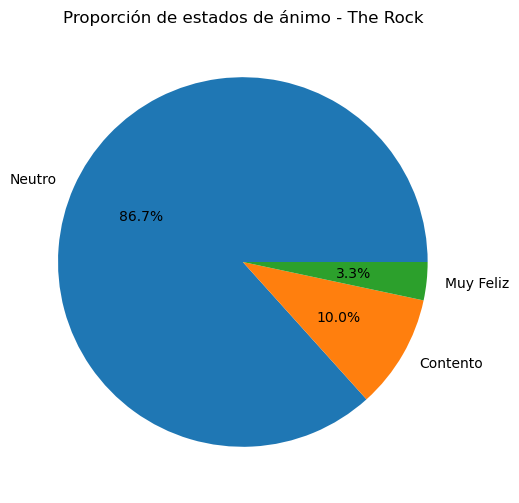

In [42]:
plt.figure(figsize=(6, 6))
plt.pie(prop_therock, labels=prop_therock.index, autopct='%1.1f%%')
plt.title('Proporción de estados de ánimo - The Rock')
plt.show()

Exportamos el **tweets_andrew** como csv


In [75]:
tweets_andrew.to_csv('tweets_andrew_etiquetados.csv', index=False,encoding='utf-8')

Creamos un Data Frame para **tweets_andrew_etiquetados.csv**

In [76]:
df_andrew = pd.read_csv('tweets_andrew_etiquetados.csv')
df_andrew

,tweet_andre_tate,prediccion
0,If The Matrix has proof of you doing something...,Neutro
1,I would never kill myself,Neutro
2,The level of stress I tolerate daily would be ...,Neutro
3,Neva catch mi with a fassy headset pon mi face...,Neutro
4,You can give most men in life a guarantee of v...,Neutro
5,The Matrix wants the best for you. The rules a...,Neutro
6,A lot of people comment on the fact I have a s...,Neutro
7,The reason I work so hard when I make over 10 ...,Contento
8,Hello @hollywills . You fooled absolutely nobo...,Neutro
9,Alex Jones was right. But its not the frogs th...,Neutro


Calculamos las proporciones de cada etiqueta para los tweets de Andrew Tate

In [77]:
prop_andrew = df_andrew['prediccion'].value_counts(normalize=True)

Visualizamos estas proporciones con un pie chart

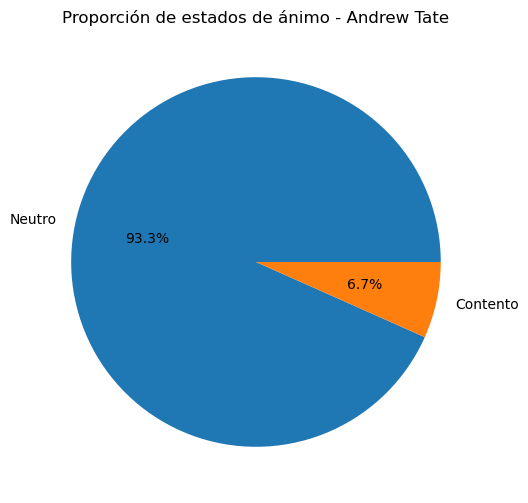

In [78]:
plt.figure(figsize=(6, 6))
plt.pie(prop_andrew, labels=prop_andrew.index, autopct='%1.1f%%')
plt.title('Proporción de estados de ánimo - Andrew Tate')
plt.show()

Comparamos las proporciones de ambos gráficos

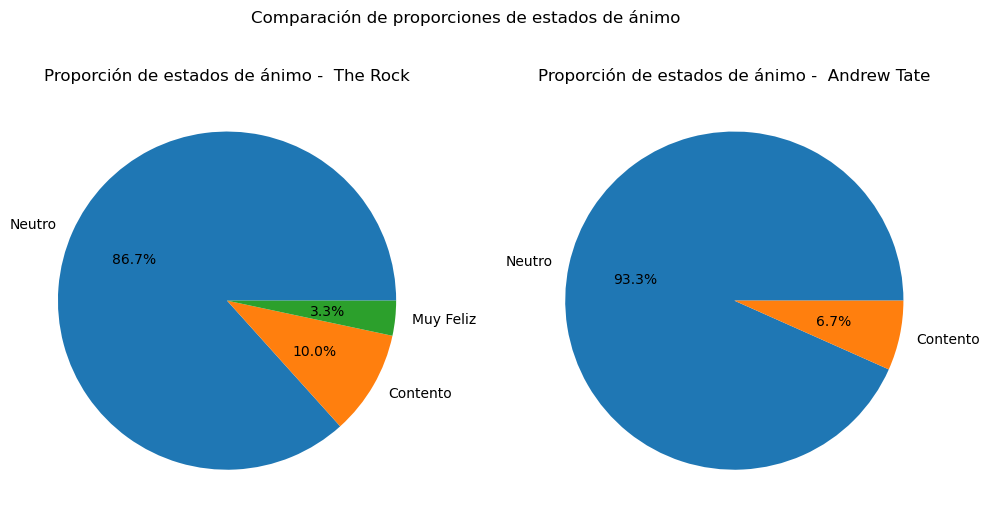

In [82]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].pie(prop_therock, labels=prop_therock.index, autopct='%1.1f%%')
ax[0].set_title('Proporción de estados de ánimo -  The Rock')

ax[1].pie(prop_andrew, labels=prop_andrew.index, autopct='%1.1f%%')
ax[1].set_title('Proporción de estados de ánimo -  Andrew Tate')

plt.suptitle('Comparación de proporciones de estados de ánimo')
plt.show()